# Convolutional Model of MNIST For Multipoint Detection

This is the first step in messing around with the YOLO approach for detecting multiple objects in an image. Using MNIST numbers randomly distributed on a black background. The model puts random images of numbers onto the background, and resizes them randomly between [0.75,1.5]. Smaller than 0.75 is too hard for a human to see, larger than 1.5 is too large on the background.


In [1]:
import numpy as np
import cv2

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda
from keras.layers import Reshape, concatenate,Concatenate
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import losses
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

Using TensorFlow backend.


In [2]:
batch_size = 24
num_classes = 10
epochs = 5
n_images = 2

# Shape of the large images we are putting the numbers into
large_image_shape = (64,64)

# Checkpoint folder
model_data_folder = "/dataset/MNIST_Tracking/Convolutional_MNIST_Multipoint_Detection_data/"

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
    input_shape = (1,x_test.shape[1], x_test.shape[2])
else:
    x_train = x_train.reshape(x_train.shape[0],  x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    input_shape = (x_test.shape[1], x_test.shape[2], 1)

In [4]:
def generate_inputs(x,y,batch_size = 128, n_classes = 10, large_image_shape = (64,64),n_images = 2):
    '''
    Using an MNIST number, make a video with the number randomly located and moving.
    
    n_classes: 10, fixed for MNIST
    large_image_shape: the shape of the output video
    max_speed: The max speed the number can travel across the frame in pixels/frame
    '''      
    scale_range = [.75,1.5] # range at which to scale the images    
    scales = np.linspace(scale_range[0],scale_range[1],n_images+1) # get scale ranges for each anchor box.
    
    n_samples,n_rows,n_cols,n_chan = x.shape
    num_batches = np.round(float(n_samples)/float(batch_size)-.5)
    
    y = keras.utils.to_categorical(y, n_classes)
    
    while 1:
        sample_order = np.random.permutation(x.shape[0])
        x_out = np.zeros((batch_size,large_image_shape[0],large_image_shape[1],n_chan),dtype = x.dtype)
        location_out = np.zeros((batch_size,1,1,n_images,2))
        class_out = np.zeros((batch_size,1,1,n_images,n_classes))

        permute_counter = 0
        for ii in range(batch_size):
            for jj in range(n_images):
                permute_counter += 1
                # find how large the new image is. Do some halfing and doubling so we end up with even dimensions
                # even dimensions make placing into the large image easier
                img_scale = np.random.uniform(scales[jj],scales[jj+1])
                n_rows_scale = 2*np.around(n_rows * img_scale/2).astype(np.uint8)
                n_cols_scale = 2*np.around(n_cols * img_scale/2).astype(np.uint8)
                # initialize the limits on where the the number can start
                limits = np.array([[int(n_rows_scale/2),large_image_shape[0]-int(n_rows_scale/2)],
                                   [int(n_cols_scale/2),large_image_shape[1]-int(n_cols_scale/2)]])

                #initialize and create starting point
                location = np.zeros((2))
                location[0] = np.random.randint(limits[0,0],limits[0,1])
                location[1] = np.random.randint(limits[1,0],limits[1,1])
                location = location.astype(np.int)
                # convert to relative distance across image
                location_out[ii,0,0,jj,0]=location[0]/large_image_shape[0]
                location_out[ii,0,0,jj,1]=location[1]/large_image_shape[1]
                
                # Resize the image and place into output image.
                # Note that this can cause an overflow if the images overlap.
                # a small image on a large image will make the small image appear as a negative.
                x_scaled = cv2.resize(x[sample_order[permute_counter]],(n_rows_scale,n_cols_scale))
                x_scaled = np.expand_dims(x_scaled,axis = -1)
                x_out[ii,
                      int(location[0] - n_rows_scale/2):int(location[0] + n_rows_scale/2),
                      int(location[1] - n_cols_scale/2):int(location[1] + n_cols_scale/2),:] += x_scaled

                class_out[ii,0,0,jj,:] = y[sample_order[permute_counter]]
                
        x_out = x_out.astype(np.float32)/255.
        
        yield (x_out,[location_out,class_out])

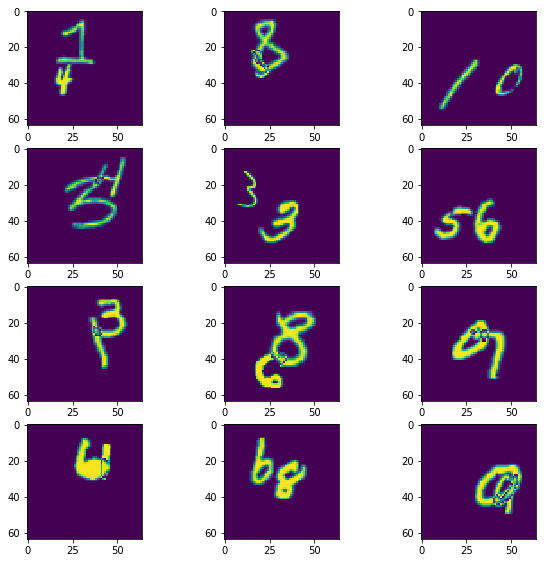

In [5]:
# Take a look at what the images look like
plt.rcParams['figure.figsize'] = (10,30)
dev_batch_size = 12
num_batches = 1

t = generate_inputs(x_train,y_train,batch_size = dev_batch_size, n_classes = 10, n_images=n_images,large_image_shape=large_image_shape)

batch_counter = 0 
for ii in t:
    batch_counter += 1
    data = ii[0]
    n_cols = 3
    n_rows = dev_batch_size
    counter = 0
    img_shape = data[0,:,:,0].shape
    y = ii[1]
    for jj in range(dev_batch_size):
        counter += 1
        plt.subplot(n_rows,n_cols,counter)
        #plt.title('{}'.format(np.argmax(ii[1][jj,0,0,2:])))
        plt.imshow(data[jj,:,:,:].reshape(img_shape[0],img_shape[1]))
    plt.show()
    if batch_counter >= num_batches:
        break


In [6]:
def head(x):
    
    # reshape the input, shape is: [num_rows,num_cols,num_to_detect, classes + location]
    x = Reshape((1,1,n_images,12))(x)

    locs = Lambda(lambda locs:K.sigmoid(x[:,:,:,:,:2]),name='sigmoid_locs')(x) # get locations on [0,1]
    classes = Lambda(lambda classes:K.softmax(x[:,:,:,:,2:]),name='softmax_classes')(x) # so we can use cross entropy

    return locs,classes

def locs_loss(y_true,y_pred):
    
    #scale = np.log(10)/((28./64.)**2) = 12.03
    loss = 12.03 * losses.mean_squared_error(y_true,y_pred)
    return loss

def class_loss(y_true,y_pred):

    #classes = K.softmax(y_pred[:,:,:,2:])
    loss = losses.categorical_crossentropy(y_true,y_pred)

    return loss

def class_acc(y_true,y_pred):
    
    return metrics.categorical_accuracy(y_true,y_pred)

In [7]:
train_gen = generate_inputs(x_train,y_train,batch_size = batch_size, n_classes = 10,n_images=n_images,large_image_shape = large_image_shape)
test_gen = generate_inputs(x_test,y_test,batch_size = batch_size,n_classes = 10,n_images=n_images,large_image_shape = large_image_shape)

In [8]:
from keras.layers import Input
from keras.models import Model

main_input = Input(shape=(large_image_shape[0],large_image_shape[1],1),dtype='float32',name="main_input")
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name='Conv_01')(main_input)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name='Conv_02')(x)
x=MaxPooling2D(pool_size=(2,2),name="Maxpool_03")(x)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name="Conv_04")(x)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name="Conv_05")(x)
x=MaxPooling2D(pool_size=(4,4),name="Maxpool_06")(x)
x=Conv2D(filters=32, kernel_size=(3, 3),padding='valid',activation='relu',name="Conv_07")(x)
x=Conv2D(filters=12*n_images, kernel_size=(4,4),padding='valid',activation='linear',name='Conv_08')(x)


locs,classes=head(x)
model = Model(inputs=main_input, outputs=[locs,classes])
model.compile(loss=[locs_loss,class_loss],
              optimizer=keras.optimizers.Adadelta(),
              metrics=[class_acc])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
Conv_01 (Conv2D)                 (None, 62, 62, 32)    320         main_input[0][0]                 
____________________________________________________________________________________________________
Conv_02 (Conv2D)                 (None, 60, 60, 32)    9248        Conv_01[0][0]                    
____________________________________________________________________________________________________
Maxpool_03 (MaxPooling2D)        (None, 30, 30, 32)    0           Conv_02[0][0]                    
___________________________________________________________________________________________

In [9]:
# tensorboard
tbCallBack = keras.callbacks.TensorBoard(log_dir=model_data_folder, histogram_freq=0, write_graph=True, write_images=True)
#Checkpoints
checkpointer = ModelCheckpoint(filepath=model_data_folder + 'weights.hd5', verbose=1, save_best_only=True)
#logger
csv_logger = keras.callbacks.CSVLogger(model_data_folder+"train_log.csv", separator=',', append=False)

In [10]:
model.fit_generator(train_gen,
          steps_per_epoch = np.round(x_train.shape[0]/batch_size-.5).astype('int'),
          epochs=epochs,
          verbose=1,
          validation_data=test_gen,
          validation_steps =np.round(x_test.shape[0]/batch_size-.5).astype('int'),
          callbacks=[tbCallBack,csv_logger])#,checkpointer

Epoch 1/5
2500/2500 [==============================] - 80s - loss: 1.8854 - sigmoid_locs_loss: 0.0874 - softmax_classes_loss: 1.7979 - sigmoid_locs_class_acc: 0.8292 - softmax_classes_class_acc: 0.3517 - val_loss: 1.4846 - val_sigmoid_locs_loss: 0.0720 - val_softmax_classes_loss: 1.4126 - val_sigmoid_locs_class_acc: 0.8542 - val_softmax_classes_class_acc: 0.5030
Epoch 2/5
2500/2500 [==============================] - 76s - loss: 1.3113 - sigmoid_locs_loss: 0.0605 - softmax_classes_loss: 1.2508 - sigmoid_locs_class_acc: 0.8622 - softmax_classes_class_acc: 0.5650 - val_loss: 1.1464 - val_sigmoid_locs_loss: 0.0494 - val_softmax_classes_loss: 1.0969 - val_sigmoid_locs_class_acc: 0.8804 - val_softmax_classes_class_acc: 0.6248
Epoch 3/5
2500/2500 [==============================] - 77s - loss: 1.0420 - sigmoid_locs_loss: 0.0494 - softmax_classes_loss: 0.9925 - sigmoid_locs_class_acc: 0.8812 - softmax_classes_class_acc: 0.6648 - val_loss: 0.9239 - val_sigmoid_locs_loss: 0.0460 - val_softmax_cla

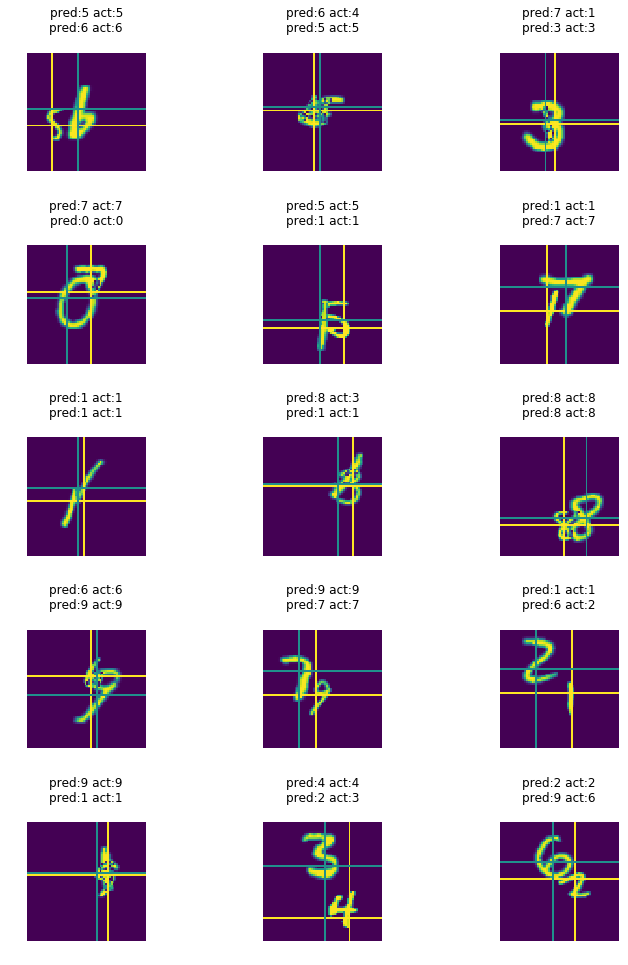

In [12]:
plt.rcParams['figure.figsize'] = (10,40)
# Take a look at what the images look like
dev_batch_size = 15
num_batches = 1

t = generate_inputs(x_train,y_train,batch_size = dev_batch_size, n_classes = 10, large_image_shape=large_image_shape)

batch_counter = 0 
for data in t:
    batch_counter += 1
    predictions = model.predict(data[0],batch_size=dev_batch_size)

    image = data[0]
    n_cols = 3
    n_rows = dev_batch_size
    counter = 0
    img_shape = image[0,:,:,0].shape
    for jj in range(dev_batch_size):
        counter += 1
        # reshape and draw the lines on the image
        img = image[jj,:,:,:].reshape(img_shape[0],img_shape[1])
        #get the rows and colums of each prediction
        
        title = ''
        for anchor in range(2):
            r = int(predictions[0][jj,0,0,anchor,0]*img_shape[0])
            c = int(predictions[0][jj,0,0,anchor,1]*img_shape[1])
            img[r,:] = 1-anchor/2.
            img[:,c] = 1-anchor/2.

            label = np.argmax(data[1][1][jj,0,0,anchor,:])
            predicted = np.argmax(predictions[1][jj,0,0,anchor,:])
            title += 'pred:{} act:{}\n'.format(predicted,label)
        
        plt.subplot(n_rows,n_cols,counter)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
    plt.show()
    if batch_counter >= num_batches:
        break
